In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(map(len, words)))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build vocab
chars = list(sorted(set("".join(words))))
stoi = {s: i for i, s in enumerate(["."] + chars)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [4]:
block_size = 3


def build_dataset(_words):
    X, Y = [], []
    for w in _words[:]:
        # print(w)
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )

In [6]:
n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

# Layer 1
W1 = (
    torch.randn((n_embed * block_size, n_hidden), generator=g)
    * (5 / 3)
    * ((n_embed * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# batchnorm params
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-act
# batchnorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# non linearity
h = torch.tanh(hpreact)  # hidden layer
# linear layer 2
logits = h @ W2 + b2  # output layer
# cross-entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None

for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3608, grad_fn=<NegBackward0>)

In [13]:
"""
dlogprobs:
derivative of loss w.r.t. the logprobs.
the loss in terms of logprobs is simply a mean of all the logprobs.
loss w.r.t logprobi is (-1/n) refer: [loss = -(a + b + c) / n]

dprobs:
dloss / dprobs = (dloss / dlogprobs) * (dlogprobs / dprobs)
logprobij = probij.log() -> 1/probij

dcounts_sum_inv:
dloss / dcounts_sum_inv = (dloss / dprobs) * (dprobs / dcounts_sum_inv)
considering probs is: counts * counts_sum_inv [y = ax; dy/dx = a]
-> counts * dprobs

- counts_sum_inv is first replicated row-wise 27 times & then pairwise multiplied with
counts.
- since the derivative involves `counts`, it needs to be condensed using the `sum` operation 

dcounts:
used twice cuz counts is being used in both probs as well as in counts_sum
- in first node, dcounts math is similar to dcounts_sum_inv
- in second node
dloss/dcounts = dloss/dcounts_sum * dcounts_sum/dcounts
-> counts_sum is just a summation, so derivative is always 1

dcounts_sum:
dloss/dcounts_sum = dloss/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum
dcounts_sum_inv = 1/x -> -1/x^2

dnorm_logits: trivial cuz it is just e^x whose derivative is e^6

dlogits: two nodes like counts
dloss/dnorm_logits * dnorm_logits/dlogits
norm_logits = logits - logit_maxes
c = a - b -> dc/da = 1
hence, 

dlogit_maxes: similar as above
c = a - b -> dc/db = -1

dh/dW2/db2:
dloss/dh = dloss/dlogits * dlogits/dh
since h is a matrix the math is slightly diff. can derive using a 2x2 matmul

dhpreact:
dloss/dhpreact = dloss/dh * dh/dpreact
h = tanh(x) -> dh/dx = 1 - tanh(x) ** 2 -> 1 - h**2

dbngain/dbnraw: math is similar
dloss/dbngain = dloss/dhpreact * dhpreact/dbngain
y = ax + b -> dy/dx = a
dhpreact/dbngain = bnraw

dbnbias:
...

# sums in forward pass become broadcasts in backward pass
# broadcasts in forward pass become sums in backward pass

dbndiff2:
depends on dbnvar cuz bnvar is: y = (1 / (n-1)) * x.sum(0, keepdim=True)
hence dy/dx = 1/(n-1) . however, this differential is broadcast thru
a matrix of size x cuz bnvar is expressed by a summation.

dC:
- emb is created by indexing into C such that each row in Xb selects a row of C atleast once.
- hence backbrop of C is just demb flowing back and accumulating such that
  every time a row of C was reused, it is represented as sum of the demb.

emb.shape: (32, 3, 10) -> every char is a vector of 10. 3 chars due to context. 32 iterations.
C.shape: (27, 10) -> every char is represented in 10 dims. 27 chars in vocab
Xb.shape: 32 inputs. each input is 3-dimensional

- demb is same shape as emb - (32, 3, 10).
- dC is however same shape as C - (27, 10). hence dimensionality of demb will be reduced while creating dC


"""

torch.Size([32, 3, 10])


In [14]:
# a11 a12
# a21 a22
# -->
# b1 b2 where:
# b1 = 1 / (n - 1) * (a11 + a21) col wise sum
# b2 = 1 / (n - 1) * (a12 + a22)

In [15]:
# backprop the whole thing manually.

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n

dprobs = (1.0 / probs) * dlogprobs  # low probs get boosted.

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs  # first touchpoint
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = (counts) * dcounts
dlogits = torch.ones_like(logit_maxes) * dnorm_logits

# logit_maxes is only for numerical stability & inherently has no bearing on the
# loss. this is further confirmed by extremely small values of dlogit_maxes
dlogit_maxes = (-torch.ones_like(logit_maxes) * dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5) ** -1.5 * dbnvar_inv
dbndiff2 = (1.0 / (n - 1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(dbndiff) * dbndiff).sum(0, keepdim=True)
dhprebn += 1.0 / n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):  # row-wise iter on Xb
    for j in range(Xb.shape[1]):  # col-wise iter on Xb
        ix = Xb[k, j]  # one char. C[ix] is hence embedding vector of that char.
        dC[ix] += demb[k, j]

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnraw", dbnraw, bnraw)
cmp("bnbias", dbnbias, bnbias)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)
cmp("embcat", dembcat, embcat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [16]:
# mathematically cross-entropy can be expressed as a single math expression
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp("logits", dlogits, logits)  # diff is super duper small; almost negligible

# dlogits of an output is almost 0 cuz the correct output & remaining outputs
# get somehow balanced out.
print(dlogits[0] * n, F.softmax(logits, 1)[0], dlogits[0].sum())

logits          | exact: False | approximate: True  | maxdiff: 6.752088665962219e-09
tensor([ 0.0718,  0.0820,  0.0197,  0.0467,  0.0220,  0.0818,  0.0257,  0.0368,
        -0.9816,  0.0304,  0.0381,  0.0382,  0.0375,  0.0268,  0.0339,  0.0143,
         0.0089,  0.0186,  0.0161,  0.0553,  0.0508,  0.0222,  0.0265,  0.0707,
         0.0605,  0.0250,  0.0211], grad_fn=<MulBackward0>) tensor([0.0718, 0.0820, 0.0197, 0.0467, 0.0220, 0.0818, 0.0257, 0.0368, 0.0184,
        0.0304, 0.0381, 0.0382, 0.0375, 0.0268, 0.0339, 0.0143, 0.0089, 0.0186,
        0.0161, 0.0553, 0.0508, 0.0222, 0.0265, 0.0707, 0.0605, 0.0250, 0.0211],
       grad_fn=<SelectBackward0>) tensor(9.3132e-10, grad_fn=<SumBackward0>)


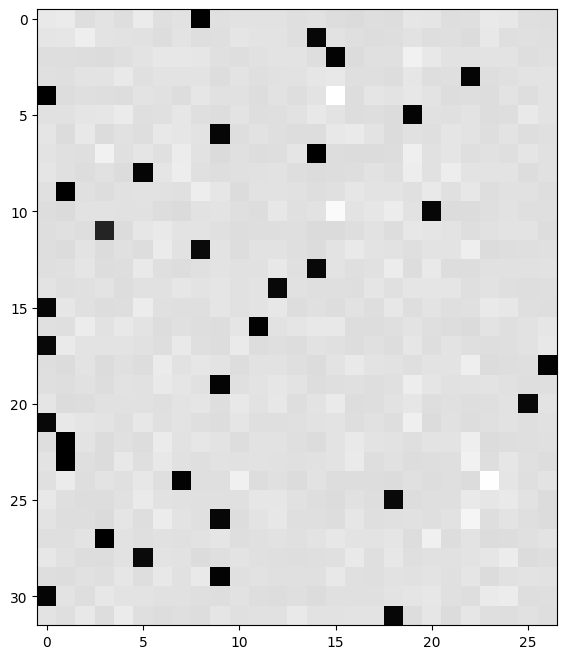

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap="gray")